<a href="https://colab.research.google.com/github/saralieber/CS_Studio/blob/master/s20_chapter6_handout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1>Chapter 6</h1>
</center>

In this chapter we will make some final tune-ups to the Naive Bayes algorithm. Then you can do the fun part: check how well it does with the Gothic authors (spoiler alert: not bad).
<hr>

#1. First let's bring in puddles


<img src='https://www.dropbox.com/s/zv84ew76m7ptyrh/puddles.jpeg?raw=1' height=100>

In [0]:
#flush the old directory
!rm -r  'uo_puddles'

In [0]:
my_github_name = 'uo-puddles'

In [0]:
clone_url = f'https://github.com/{my_github_name}/uo_puddles.git'

In [57]:
#this adds the library to colab so you can now import it
!git clone $clone_url  


Cloning into 'uo_puddles'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 228 (delta 135), reused 64 (delta 33), pack-reused 0
Receiving objects: 100% (228/228), 57.48 KiB | 700.00 KiB/s, done.
Resolving deltas: 100% (135/135), done.


In [0]:
import uo_puddles.uo_puddles as up

#2. Now bring in spacy.

In [0]:
import spacy

In [60]:
#you first have to get colab to download it locally

!python -m spacy download en_core_web_md


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
#now you can import the dictionary and set up a parser

import en_core_web_md
nlp = en_core_web_md.load()  #huh?

#3. Bring in data set


&nbsp;<br>&nbsp;<br>
<center>
<img src='https://www.thegreatcoursesdaily.com/wp-content/uploads/2017/03/Mary-Shelly-Featured-Image-LARGE.jpg' height='150' >
&nbsp;&nbsp;&nbsp;&nbsp;
<img src ='https://www.riverwoodwinery.com/uploads/1/2/4/1/124189002/s593933943352694433_p9_i1_w593.jpeg' height='150'>
&nbsp;&nbsp;&nbsp;&nbsp;
<img src='https://wpcdn.us-midwest-1.vip.tn-cloud.net/www.rimonthly.com/content/uploads/2017/05/13135413/4b8e1f244f4e0e42bf881efabd19aa12-AU5EC102CUR.jpg' height='150'>
</center>



In [0]:
import pandas as pd

In [63]:
gothic_sentences = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQqRwyE0ceZREKqhuaOw8uQguTG6Alr5kocggvAnczrWaimXE8ncR--GC0o_PyVDlb-R6Z60v-XaWm9/pub?output=csv',
                          encoding='utf-8')
len(gothic_sentences) #how many sentences

19579

In [0]:
pd.set_option('display.max_colwidth', None)  #None forces all of sentence to be shown

In [65]:
gothic_sentences.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL


#4. Compute holdout data

In [0]:
our_seed = 1234  #if we all use this we should get same random data

In [0]:
import numpy as np  #powerful library for manipulating data
rsgen = np.random.RandomState(our_seed)  #we are only going to use numpy's random number generator for now

In [0]:
shuffled_table = gothic_sentences.sample(frac=1, random_state=rsgen).reset_index(drop=True)

In [69]:
len(shuffled_table)

19579

In [70]:
19579*.7  #split point

13705.3

In [0]:
training_table = shuffled_table[:13705].reset_index(drop=True)  #.7
testing_table = shuffled_table[13705:].reset_index(drop=True)   #.3

Now pull the sentences into list of strings.

In [0]:
training_text = training_table['text'].to_list()
training_authors = training_table['author'].to_list()

In [0]:
testing_text = testing_table['text'].to_list()
testing_authors = testing_table['author'].to_list()

#5. Bring in word bag


In [0]:
import pandas as pd

In [0]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQR107nAfeU_z-p6sUv3yhnti9vNsklgXsm2RXAExQBHPUE3APm32qMQxTuYCEBbSz09MCVx-rnOXGb/pub?output=csv'


In [0]:
sorted_word_table = pd.read_csv(url, dtype={'word':str}, encoding='utf-8',
                                index_col='word', na_filter=False)
sorted_word_table = sorted_word_table.rename(index={'TRUE': 'true', 'FALSE': 'false'}) #need this because of bug in reading from url

In [77]:
sorted_word_table.head()

,EAP,MWS,HPL
word,,,
ab,1,0,0
aback,2,0,0
abaft,0,1,0
abandon,3,1,2
abandoned,8,4,8


#6. Now, about those zero values

The Naive Bayes algorithm is rather strict on zeroes. Reminder of the formula:

<img src='https://www.dropbox.com/s/gstzvvtvh9b39o8/bayes.png?raw=1'>

Because we are taking the product and not the sum in the denominator, any P(Ei|O) that is zero will cause the entire probability to be zero. This makes sense in some ideal setting where we know everything. In particular, we know all the works by each author and we know what words they used absolutely. So if we get a P(indefinite|EAP) as zero, then we absoultely can remove EAP from consideration.

Kind of bold of us to say we know everything. Laplace took this question up as well under a different guise.

#Laplace was smooth

<img src='https://www.dropbox.com/s/1qjraurrneanzjo/Screenshot%202019-09-27%2013.47.01.png?raw=1'>

From his bio: <i>Laplace is remembered as one of the greatest scientists of all time. Sometimes referred to as the French Newton or Newton of France, he has been described as possessing a phenomenal natural mathematical faculty superior to that of any of his contemporaries. He was Napoleon's examiner when Napoleon attended the École Militaire in Paris in 1784. Laplace became a count of the Empire in 1806 and was named a marquis in 1817, after the Bourbon Restoration.
Laplace died in Paris in 1827. His brain was removed by his physician, François Magendie, and kept for many years, eventually being displayed in a roving anatomical museum in Britain. It was reportedly smaller than the average brain.</i>

Cool, but what does that have to do with us? Well, Laplace was also into thought experiments. He was thinking about the probability that the sun would **not** rise in the morning.
His thought was that given a large sample of days with the rising sun, we still can not be completely sure that it will rise tomorrow. So the probability of it not rising is not zero, even though we have no evidence of it to date. He proposed adding a small smoothing constant to each conditional probability. In essence, he did not like probablities of 0. He thought a 0 led to us thinking we knew more than we actually did.



#9. The Laplace smoothing factor

I hope you see that Laplace was correct when it comes to our hold-out method. We can easily see a word in the testing set that does not appear in the training set. And if it does not appear in the training set, then it is not in our word bag. My default would be to give a zero to such a word. But that means we will end up with a probability of zero for all 3 authors. Not good!

I can boil down the Laplace smoothing factor, to mitigate this unseen word problem, as follows:

1. For `P(oliver|EAP)` we normally have (a) how many times EAP used `oliver` divided by (b) how many sentences EAP wrote. I am going to modify the numerator by adding 1. So if the numerator is 0, which it is in this case, it becomes 1. If it was 1, it becomes 2. Just add 1 in all cases. In essence, this is like **adding 1 to all the words in the EAP column**.

2. If a word is unseen (does not appear in word bag), then I treat it as 0 count. But then I add 1 to it.

3. Now we have the problem that we have "shifted" the EAP column by 1*|V|, where V is the vocabulary and |V| is the number of words we have in V, i.e., the length of the sorted_word_table. To compensate, I am going to divide by |V|. 

We should now never get a value of zero for any `P(word|author)` that we need to calculate. 

Whew.



##Side note

The smoothing value of 1 may not be the best. Some have argued (see link below) that it gives too much weight to outliers. They argue for something closer to .001. So add .01 to numerator and .01*|V| to denominator.

http://www.cs.virginia.edu/~kc2wc/teaching/NLP16/slides/03-smooth.pdf

In the end, it is yet another hyperparameter that you may need to explore. We will stick with 1 for our purposes.

##Let's run through by hand again with new concepts

##Probabilites of authors P(O)

These will not change - they are constant. So we only have to compute them once then can reuse them in the formula.

In [78]:
v_size = len(sorted_word_table)  #i.e., |V|
v_size  #21552

21552

In [79]:
n = len(training_table)  #number of sentences total
n  #13705

13705

In [80]:
eap_count = training_authors.count('EAP')
eap_count  #5470

5470

In [81]:
mws_count = training_authors.count('MWS')
mws_count  #4278

4278

In [82]:
hpl_count = training_authors.count('HPL')
hpl_count  #3957

3957

In [83]:
p_eap = eap_count/n  #P(EAP)
p_eap  #0.39912440715067493

0.39912440715067493

In [84]:
p_mws = mws_count/n  #P(MWS)
p_mws  #0.31214885078438526

0.31214885078438526

In [85]:
p_hpl = hpl_count/n  #P(HPL)
p_hpl  #0.2887267420649398

0.2887267420649398

##Compute P(indefinite|EAP)

First, the old way.

In [86]:
#count the number of sentences eap wrote. Out of those, how many used indefinite?
p_indefinite_eap_old = sorted_word_table.loc['indefinite', 'EAP']/eap_count # sorted_word_table is just from the training set
p_indefinite_eap_old  #0.0018281535648994515

0.0018281535648994515

Now with Laplace smoothing.

In [0]:
total_vocab = len(sorted_word_table)  #how many unique non-stop words we found

In [88]:
indefinite_count = 0  #start with assuming the word has not been seen before
if 'indefinite' in sorted_word_table.index:
  indefinite_count = sorted_word_table.loc['indefinite', 'EAP']  #if has been seen so get its value

p_indefinite_eap = (indefinite_count + 1)/(eap_count + v_size)  #laplace smoothing
p_indefinite_eap  #0.00040707571608319146

0.00040707571608319146

Let's try 'oliver'. EAP never used it according to the training set.

In [89]:
oliver_count = 0  #in case it is a word that has not been seen
if 'oliver' in sorted_word_table.index:
  oliver_count = sorted_word_table.loc['oliver', 'EAP']  #if has been seen get its value

p_oliver_eap = (oliver_count + 1)/(eap_count + v_size)
p_oliver_eap  #3.7006883280290134e-05

3.7006883280290134e-05

In [90]:
(0 + 1)/(eap_count + v_size) #just checking. We know oliver_count is 0.

3.7006883280290134e-05

Small, but not zero. Laplace would be happy.

#10. Ignore denominator

How about P(indefinite)? I'm going to ignore it. What, you say, you are going to throw out all those P(word) terms? You can't just willy-nilly remove things. But I can :)

First part of argument. Those P(Ei) terms are the same in each of the 3 instances we need to compute.
<pre>
P(EAP|E1, E2 ...) = ...
P(MWS|E1, E2 ...) = ...
P(HPL|E1, E2 ...) = ...
</pre>
So I can treat denominator as a constant. Now check this out.


In [91]:
p1 = .5
p2 = .4

p1 > p2

True

In [92]:
c = .01  #our simulated denominator

p1/c > p2/c

True


Second part of argument. I can use the mathematical notion of proportionality to remove them without changing the ordering of the 3 probabilities. For instance, if P(EAP|E1, E2 ...) > P(MWS|E1, E2 ...) when I include them, the same will hold when I remove them.

That helps. Speeds things up and allows us to avoid dealing with P(Ei) = 0 which would give us a zero in the denominator. Cool.

#11. Underflow or The vanishing gradient

A new problem has arisen with Naives Bayes, one that was not an issue with the distance measures we used for KNN. The new problem is taking the product of very small numbers. In essence, calculating the numerator in Naive Bayes. Multiplying a set of very small numbers in Python can cause what is called *underflow*. What happens is that the product gets so small that Python turns the final result into zero. This is kind of bad. Defeats our whole process of adding a smoothing factor. Let me see if I can show you with an example.

In [93]:
s = testing_text[5457]  #a sentence from our testing text
s

'To chambers of painted state farewell To midnight revelry, and the panting emulation of beauty, to costly dress and birth day shew, to title and the gilded coronet, farewell Farewell to the giant powers of man, to knowledge that could pilot the deep drawing bark through the opposing waters of shoreless ocean, to science that directed the silken balloon through the pathless air, to the power that could put a barrier to mighty waters, and set in motion wheels, and beams, and vast machinery, that could divide rocks of granite or marble, and make the mountains plain Farewell to the arts, to eloquence, which is to the human mind as the winds to the sea, stirring, and then allaying it; farewell to poetry and deep philosophy, for man\'s imagination is cold, and his enquiring mind can no longer expatiate on the wonders of life, for "there is no work, nor device, nor knowledge, nor wisdom in the grave, whither thou goest" to the graceful building, which in its perfect proportion transcended th

In [0]:
doc = nlp(s)

In [95]:
len(doc)  #436 words before removing stop words. A long sentence!

436

In [0]:
s_list = []

for i in range(len(doc)):
  token = doc[i]
  if token.is_alpha and not token.is_stop:
    s_list.append(token.text)

s_list

In [97]:
len(s_list)  #205 legit words. Still a lot.

205

Yikes. 205 tokens in the sentence.

Let's get the 205 values for P(Ei|EAP).

In [98]:
p_ei_eap_list = []

for word in s_list:
  count = 0
  if word in sorted_word_table.index:
    count = sorted_word_table.loc[word, 'EAP']
  result =  (count+1)/(eap_count + v_size)  #using smoothing
  p_ei_eap_list.append(result)

p_ei_eap_list

[0.0002220412996817408,
 0.00018503441640145066,
 0.0016653097476130561,
 0.0001110206498408704,
 0.0005921101324846421,
 3.7006883280290134e-05,
 7.401376656058027e-05,
 3.7006883280290134e-05,
 0.0011472133816889942,
 7.401376656058027e-05,
 0.0006291170157649323,
 0.00014802753312116054,
 0.004255791577233365,
 3.7006883280290134e-05,
 0.0005180963659240619,
 0.0001110206498408704,
 3.7006883280290134e-05,
 0.0001110206498408704,
 3.7006883280290134e-05,
 0.00014802753312116054,
 0.00048108948264377177,
 0.006624232107171934,
 0.0009991858485678337,
 3.7006883280290134e-05,
 0.0017763303974539263,
 0.0009251720820072533,
 0.00018503441640145066,
 3.7006883280290134e-05,
 0.00037006883280290133,
 3.7006883280290134e-05,
 0.0006291170157649323,
 0.0007031307823255126,
 0.0003330619495226112,
 7.401376656058027e-05,
 0.0019983716971356674,
 3.7006883280290134e-05,
 0.0026644955961808896,
 0.0015912959810524758,
 3.7006883280290134e-05,
 0.0003330619495226112,
 0.00037006883280290133,
 

I am going to break out what float_product does so we can examine it more closely. If I see the product go to 0, I'll print at what value it happened. Just as reminder, it should never be 0 given all the values in p_ei_eap_list are above 0.

In [99]:
product = 1.

for i in range(len(p_ei_eap_list)):
  p = p_ei_eap_list[i]
  product = product * p
  if product == 0:
    print(i)
    break  #new Python operator. It says pretend the loop has finished.

92


So we got to 0 on the 92nd item in the list. It will now stay 0 for the other 112 items.

##This is an example of the vanishing gradient

Technically, the jargony term *vanishing gradient* shows up later in neural net models. But I think it applies here in spirit. I like the term because of the "vanishing" piece: as things get smaller and smaller, the result eventually vanishes (becomes zero). That is what is happening here. The product is getting smaller and smaller and eventually vanishes at index 92.

#12. Smallest Python float

This begs the question how low can you go (limbo music plays in background)? What is the smallest float Python can represent?

Check it out.

In [100]:
import sys
sys.float_info.min  #smallest float value possible

2.2250738585072014e-308

Here is what I propose. If a product drops to zero (through underflow), we set the product to the minimum Python float value seen above. This avoids returning a zero probablity from Naive Bayes. We have earlier used smoothing to handle some zero values. Now we are handling the second form of zero we might see. We are good to go!

#Summary

We started with Naive Bayes out of the box in Chapter 5. This week we have refined it by (a) adding a Laplace smoothing factor, (b) eliminating the denominator, and (c) avoiding underflow when taking the products of very small numbers in Python.

#13. Ready to evaluate

I packaged everything up for you into a puddles function. It handles smoothing and underflow. Given a test sentence and word bag built from the training set, it will give you the 3 values from calculating Naive Bayes. Check it out.

In [0]:
e_list = ['laugh', 'oliver', 'grandfather', 'wo', 'ride', 'motor']  #from chapter 5

In [104]:
up.bayes_gothic(e_list, sorted_word_table, training_table)  #(4.797878011973764e-25, 6.306182771405084e-26, 5.553115651723025e-23)

(4.797878011973764e-25, 6.306182771405085e-26, 5.553115651723025e-23)

HPL was the actual author of the sentence so we got it right. He has the largest value. Nice. Our first win using Naive Bayes.

#Assignment 1.
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Get your predictions by running Naive Bayes on the testing set. Note that this is a 2 step process: (1) get the triples for each sentence, (2) get the predictions by taking the max of each triple.

##Step 1.

Produce the list of triples. So no predictions yet. Just a list of the results from `up.bayes_gothic`.

This took me 3 minutes.

In [0]:
test_sentences = []

for i in range(len(testing_text)):
  sentences = testing_text[i].lower()
  test_sentences.append([sentences]) # make each sentence its own list

In [0]:
test_sentences[:10]

In [0]:
testing_text[:10]

In [120]:
len(test_sentences) # 5874 sentences - as lists
len(testing_text) # 5874 sentences - as strings

5874

In [129]:
testing_text[0]
doc = nlp(testing_text[0])
doc[:5]

In the confusion attending my

In [146]:
parsed_sentences = [[]]
tokens_per_sentence = []

for i in range(len(testing_text)):
  doc = nlp(testing_text[i].lower()) 
  parsed_sentences.append(doc)
  tokens = parsed_sentences[nlp(doc)]

  for token in doc:  
    if token.is_alpha and not token.is_stop:
      tokens_per_sentence.append(token.text)

TypeError: ignored

In [145]:
tokens_per_sentence[0]

'confusion'

In [143]:
tokens_per_sentence = []

for i in range(len(parsed_sentences)):
  doc = nlp()

  for token in sentences:  
    if token.is_alpha and not token.is_stop:
      tokens_per_sentence.append(token.text)

AttributeError: ignored

In [133]:
%%time

#your code here

result_list = []

for i in range(len(token_list)):
  items = token_list[i]
  result = up.bayes_gothic(items, sorted_word_table, training_table)
  result_list.append(result)

CPU times: user 5min 4s, sys: 73 ms, total: 5min 4s
Wall time: 5min 4s


In [134]:
result_list[:5]

[(0.00019201455454662033, 2.41694812841181e-05, 0.00010186760275136064),
 (0.0001181628027979202, 6.042370321029525e-05, 5.6593112639644795e-05),
 (0.00031017735734454054, 0.0002175253315570629, 0.00014714209286307645),
 (0.0010486948748315418, 0.0001208474064205905, 0.00010186760275136064),
 (2.954070069948005e-05, 1.208474064205905e-05, 1.131862252792896e-05)]

Here is what I got for result_list first 5.

<pre>
[(2.3119092333109343e-46, 5.026792223582086e-54, 2.4787413489091447e-51),
 (6.959717796952573e-45, 1.5140406188464093e-42, 3.3069010682386025e-42),
 (5.395832479210548e-48, 9.28028679134852e-51, 4.297064611846296e-50),
 (3.996284558172596e-56, 9.060867036238493e-53, 2.1497919775490074e-57),
 (1.219086935483253e-66, 1.0246639306144965e-70, 5.009110759153542e-68)]
 </pre>

##Step 2.

Now get predictions. Find the max author in each triple and make that author your prediction.

Here is some code that might help.

In [0]:
authors = ['EAP', 'MWS', 'HPL']

a_triple = [.5, .4, .3]  #simulates the 3 values you get from up.bayes_gothic

m = max(a_triple)  #what is the max value?  .5 in our case
j = a_triple.index(m)  #where is it found?  index 0 in our case
a = authors[j]  #corresponding author       "EAP" in our case
prediction = a  #record the prediction

prediction

'EAP'

In [0]:
#your code below


predictions[:10]  #['EAP', 'HPL', 'EAP', 'MWS', 'EAP', 'EAP', 'EAP', 'EAP', 'EAP', 'MWS']

['EAP', 'HPL', 'EAP', 'MWS', 'EAP', 'EAP', 'EAP', 'EAP', 'EAP', 'MWS']

In [0]:
testing_authors[:10]  #['EAP', 'MWS', 'EAP', 'MWS', 'EAP', 'EAP', 'EAP', 'EAP', 'EAP', 'MWS']

['EAP', 'MWS', 'EAP', 'MWS', 'EAP', 'EAP', 'EAP', 'EAP', 'EAP', 'MWS']

#Assignment 2.
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Go ahead and compute accuracy. I got a value of `0.8180115764385427`.

In [0]:
#your code



In [0]:
accuracy  #0.8180115764385427

0.8180115764385427

#13. A plot in place of confusion matrix

We can use a heat-map to give us a view into the 9 cases we now have. Yellow is large values, green medium and purple low.

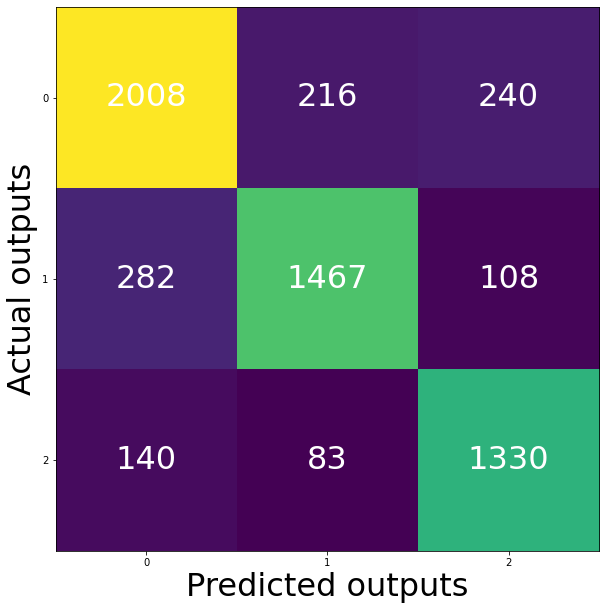

In [0]:
up.heat_map(zipped, ['EAP', 'MWS', 'HPL'])  #EAP=0, MWS=1, HPL=2

##What would a cost model look like?

A bit of a stretch, but let's say that it is costly to falsely predict EAP. You can see we have 2 false-negative cases in column 0: predicting EAP when it was MWS; predicting EAP when it was HPL. These mistakes are costly because the price for legit EAP sentences is high. Investors are willing to fork out big bucks for legit EAP sentences (bigggg stretch). If we predict a sentence is EAP, someone buys it for a high price, and they later discover it is not authored by EAP, we get sued. So we might consider ways of lowering (0,1) and (0,2) cells, 282 and 140 respectively.

Sorry, that is my best shot at a back-story.

#14. Multinomial versus Bernoulli

We are using Multinomial Naive Bayes because we are counting how many times a word occurs for an author. We could also use Bernoulli Naive Bayes where we look for features that are true or false, e.g., EAP uses the word 'oliver', true or false - don't care how many times beyond 1. This paper discusses the difference between the two: http://www.kamalnigam.com/papers/multinomial-aaaiws98.pdf.  Short answer: Multinomial wins with a large word bag, which we have.
</div>

#15. End notes

This ends our look at Naive Bayes applied to a text classification/prediction problem. What do you think? Is our accuracy result of 82% good enough? The question is whether other models, e.g., KNN, can do better?  Straight out of the gate with KNN, we would require 21K columns, one for each word in `sorted_word_bag`. We could try to reduce that 21K down to a smaller number. We will take up a related problem in the next chapter.

#On Wednesday

I'll hand out take-home midterm and go over it. It will be due before class on Monday of week 7. It will count on you being able to pull together ideas from both chapters 5 and 6.